In [8]:
from imutils.object_detection import non_max_suppression
import pytesseract
import numpy as np
import cv2
from matplotlib import pyplot as plt

%matplotlib inline

In [257]:
class Reader:
    def __init__(self, image):
        self.__image=image

    def __decode_predictions(self, scores, geometry, minconfidence):
        (numRows, numCols) = scores.shape[2:4]
        rects = []
        confidences = []

        for y in range(0, numRows):
            scoresData = scores[0, 0, y]
            xData0 = geometry[0, 0, y]
            xData1 = geometry[0, 1, y]
            xData2 = geometry[0, 2, y]
            xData3 = geometry[0, 3, y]
            anglesData = geometry[0, 4, y]

            for x in range(0, numCols):
                if scoresData[x] < minconfidence:
                    continue

                (offsetX, offsetY) = (x * 4.0, y * 4.0)

                angle = anglesData[x]
                cos = np.cos(angle)
                sin = np.sin(angle)

                h = xData0[x] + xData2[x]
                w = xData1[x] + xData3[x]

                endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
                endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
                startX = int(endX - w)
                startY = int(endY - h)

                rects.append((startX, startY, endX, endY))
                confidences.append(scoresData[x])

        return (rects, confidences)

    def locate_number(self):
        image=self.__image

        minconfidence = 0.5
        # The EAST text requires that your input image dimensions be multiples of 32, so if you choose to adjust your --width and --height values, make sure they are multiples of 32!
        height=320
        width=320
        padding=0.0
        east="frozen_east_text_detection.pb"
        (origH, origW) = image.shape[:2]

        (newW, newH) = (width, height)
        rW = origW / float(newW)
        rH = origH / float(newH)

        image_r = cv2.resize(image, (newW, newH))
        (H, W) = image_r.shape[:2]

        layerNames = [
            "feature_fusion/Conv_7/Sigmoid",
            "feature_fusion/concat_3"]

        # print("[INFO] loading EAST text detector...")
        net = cv2.dnn.readNet(east)



        blob = cv2.dnn.blobFromImage(image_r, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
        net.setInput(blob)
        (scores, geometry) = net.forward(layerNames)

        (rects, confidences) = self.__decode_predictions(scores, geometry, minconfidence)
        boxes = non_max_suppression(np.array(rects), probs=confidences)

        best_bb_start=(0,0)
        best_bb_end=(0,0)
        for (startX, startY, endX, endY) in boxes:
            startX = int(startX * rW)
            startY = int(startY * rH)
            endX = int(endX * rW)
            endY = int(endY * rH)

            dX = int((endX - startX) * padding)
            dY = int((endY - startY) * padding)

            startX = max(0, startX - dX)
            startY = max(0, startY - dY)
            endX = min(origW, endX + (dX * 2))
            endY = min(origH, endY + (dY * 2))

            if endY>best_bb_end[1]:
                best_bb_start=(startX,startY)
                best_bb_end = (endX, endY)

        """
        cv2.rectangle(image, best_bb_start, best_bb_end, (0, 0, 255), 2)
        cv2.imshow("Best bb", image)
        cv2.waitKey(0)
        """
        return best_bb_start, best_bb_end

    def __get_image_treatment(self):
        hsv = cv2.cvtColor(self.__image, cv2.COLOR_BGR2HSV)
        lower_val = np.array([0, 0, 0])
        upper_val = np.array([179, 255, 80])
        mask = cv2.inRange(hsv, lower_val, upper_val)
        masked = cv2.bitwise_not(mask)
        kernel = np.ones((5, 5), np.uint8)
        image=cv2.dilate(masked, kernel, iterations=2)
        #image= cv2.morphologyEx(masked, cv2.MORPH_OPEN, kernel)
        return cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

    def identify_number(self, bb_start, bb_end):
        #image=self.__get_image_treatment()
        image = self.__image
        (startX, startY)=bb_start
        (endX, endY)=bb_end
        # Need to especify the path only in widows systems
        # pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

        roi = image[startY:endY, startX:endX]
        config = ("-l eng --oem 1 --psm 7 -c tessedit_char_whitelist=0123456789")
        text = pytesseract.image_to_string(roi, config=config)


        #print(startX, startY, endX, endY)
        #print("{}\n".format(text))
    
        text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
        cv2.putText(image, text, (startX, startY - 20), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)
    
        cv2.imshow("Text Detection", image)
        cv2.waitKey(0)



        return text

In [2]:
img_cv = cv2.imread('./tests/data/Crotal1.TIF')

In [3]:
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

In [12]:
img_hsv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2HSV)

In [34]:
img_gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)

In [41]:
pytesseract.image_to_string(img_gray, config='--psm 7')

'E04 06 0309'

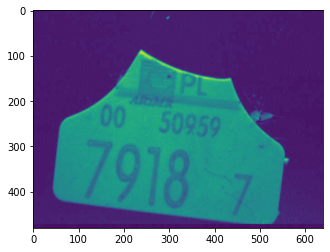

In [322]:
plt.imshow(img_gray, )
plt.show()

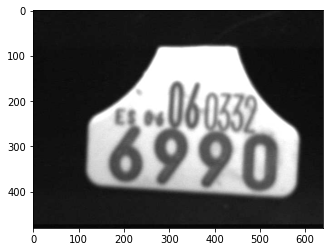

In [492]:
f = './tests/data/Crotal9.TIF'
img_cv = cv2.imread(f)
img_gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray,cmap='gray')
plt.show()

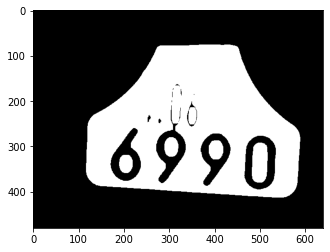

In [493]:
kernel = np.ones((5, 5),np.uint8)

foo = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
foo = cv2.erode(foo, kernel, iterations=1)
foo = cv2.dilate(foo,kernel,iterations =2)
plt.imshow(foo,cmap='gray')
plt.show()

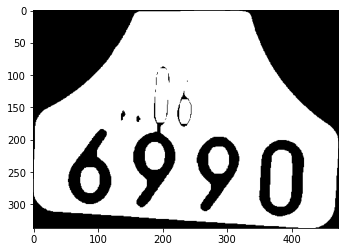

In [494]:
def trim_zeros_2D(array, axis=1):
    mask = ~(array==0).all(axis=axis)
    inv_mask = mask[::-1]
    start_idx = np.argmax(mask == True)
    end_idx = len(inv_mask) - np.argmax(inv_mask == True)
    if axis:
        return array[start_idx:end_idx,:]
    else:
        return array[:, start_idx:end_idx]
biz = trim_zeros_2D(trim_zeros_2D(foo, axis=1), axis=0)
plt.imshow(biz,cmap='gray')
plt.show()

In [489]:
# Esto no vale una mierda XD

# def rotate_image(image, angle):
#   image_center = tuple(np.array(image.shape[1::-1]) / 2)
#   rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
#   result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
#   return result
# last = biz.copy()
# for angle in range(0, 20):
#     bar = rotate_image(biz, angle)
#     aux = trim_zeros_2D(trim_zeros_2D(bar, axis=1), axis=0)
#     if aux.shape[1] < last.shape[1]:
#         last = aux
# plt.imshow(last, cmap='gray')
# plt.show()

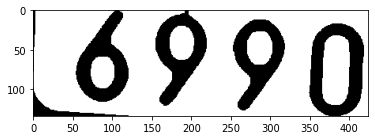

In [496]:
i = Reader(cv2.cvtColor(biz, cv2.COLOR_GRAY2BGR))
bb_start, bb_end = i.locate_number()
(startX, startY)=bb_start
(endX, endY)=bb_end
foo = biz[startY:endY, startX:endX]
plt.imshow(foo,cmap='gray')
plt.show()

In [497]:
pytesseract.image_to_string(foo, config='-l eng --oem 1 --psm 7 -c tessedit_char_whitelist=0123456789')

'6990'

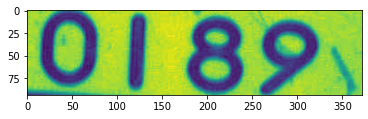

In [97]:
kernel = np.ones((5, 5), np.uint8)    
new_img2 = cv2.morphologyEx(foo, cv2.MORPH_CLOSE, kernel)
plt.imshow(foo)
plt.show()

In [ ]:
cv2.bitwise_not(thresh_gray,thresh_gray)